In [6]:
import sys
from pathlib import Path
sys.path.append(Path(sys.path[0]).parent.as_posix())

import tensorflow as tf
import numpy as np
from environments.acrobot_cont_actions import AcrobotModified
from CACLA import CACLA, training_step
from collections import deque
from tqdm.notebook import trange
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
env = AcrobotModified()
options = {
        "low": 1,
        "high": 5
    }
observation, info = env.reset(options=options)

model = CACLA(env.observation_space.shape, [1/np.pi, 1/np.pi, 1/env.MAX_VEL_1, 1/env.MAX_VEL_2], 12)

stddev = .3
discount_factor = 0.95
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

10 [4.824007  1.8307272 4.3137794 1.5971285]


  0%|          | 0/100 [00:00<?, ?it/s]

20 [2.1203039 2.8445868 1.4868788 3.0904334]


  0%|          | 0/100 [00:00<?, ?it/s]

30 [1.9431952 2.716428  1.3690921 3.370411 ]


  0%|          | 0/100 [00:00<?, ?it/s]

40 [3.919594  3.77366   4.767684  1.2386082]


  0%|          | 0/100 [00:00<?, ?it/s]

50 [4.1496906 4.334677  3.1916177 4.8937964]


  0%|          | 0/100 [00:00<?, ?it/s]

60 [2.2971354 1.1085856 1.2188835 4.961966 ]


  0%|          | 0/100 [00:00<?, ?it/s]

70 [2.5229394 3.8952234 2.2887573 4.8608956]


  0%|          | 0/100 [00:00<?, ?it/s]

80 [3.9459653 1.0736752 1.1465348 3.378829 ]


  0%|          | 0/100 [00:00<?, ?it/s]

90 [2.489331  3.7275884 3.074107  2.6734009]


  0%|          | 0/100 [00:00<?, ?it/s]

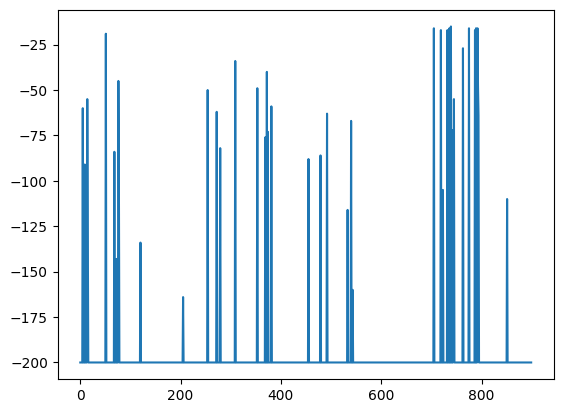

In [8]:
reward_sum_per_episode = []
n_episodes = 100

for seed in range(10, 100, 10):
    obs, _ = env.reset(seed=seed, options=options)
    print(seed, obs)
    for episode in trange(n_episodes):
        reward_sum = 0
        obs, _ = env.reset(seed=seed, options=options)
        for step in range(200):
            reward, done = training_step(env, model, stddev, discount_factor, optimizer, loss_fn)
            reward_sum += reward
            if done:
                break
        reward_sum_per_episode.append(reward_sum)

plt.plot(reward_sum_per_episode)

In [9]:
ex = np.array([.5, .5, .5, .5])[np.newaxis]
action, critic = model(ex)
print(f'Action: {action}')
print(f'Critic: {critic}')

Action: [[0.62816274]]
Critic: [[1.3028394]]


In [10]:
model.save_weights('CACLA_weights')